# TP2: Tutorial de aprendizaje por transferencia (Transfer Learning)

Tutorial inspirado del tutorial de Sasank Chilamkurthy - https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

En este tutorial, veremos cómo entrenar a su red utilizando el aprendizaje de transferencia. Puedes leer más sobre el aprendizaje de transferencia <a href="https://cs231n.github.io/transfer-learning/">aqui</a> (lectura importante para entender el tutorial).

En la práctica, muy pocas personas entrenan una red convolucional completa desde cero, porque es relativamente raro tener un conjunto de datos de tamaño suficiente. En cambio, es común entrenar previamente un ConvNet en un conjunto de datos muy grande (por ejemplo, ImageNet, que contiene 1,2 millones de imágenes con 1000 categorías), y luego utilizar el ConvNet como inicialización o como extractor de características fijas para la tarea de interés. Esta idea da origen al concepto de Transfer Learning.

Existen 2 escenarios principales de Transfer Learning: 

- <b>Perfeccionando el convnet</b>: En lugar de una inicialización aleatoria, inicializamos la red con una red preentrenada, como la que se forma en el conjunto de datos de imagenet 1000. El resto del entrenamiento se ve como de costumbre. Es decir, los parametros de cada cada se podrán optimizar.

- <b>ConvNet como extractor de características fijas</b>: En este escenario, se congelan los pesos para toda la red excepto para la última capa de la red MLP. Esta última capa <i>fully-connected</i> es reemplazada por una nueva con pesos aleatorios y sólo esta capa es entrenada.



In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

#from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

/home/fr4j4/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Cargar datos

Usaremos los paquetes de datos torchvision y torch.utils.data para cargar los datos.

El problema que vamos a resolver es entrenar un modelo para clasificar hormigas y abejas. Tenemos alrededor de 120 imágenes de entrenamiento para hormigas y abejas. Hay 75 imágenes de validación para cada clase. Por lo general, este es un conjunto de datos muy pequeño para generalizar, si se entrena desde cero. Dado que estamos utilizando el aprendizaje por transferencia, deberíamos ser capaces de generalizar razonablemente bien.

Descargar los datos y extraer al directorio actual: https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<b>Preguntas:</b>

- 1) ¿De qué sirve la clase <code>transforms</code> de TorchVision? Qué operaciones hacemos sobre las imagenes? por qué? (ver el repositorio <code>data/hymenoptera_data</code>)

- 2) ¿Cuál es la diferencia entre el dataset 'image_datasets['train']' y 'image_datasets['val']' ?

**Respuestas**<br>
 
 1. Transforms son funciones o métodos que pueden ser utilizados para transformar datos de un dataset.
 2. 'train' hacen referencia al dataset de emtrenamiento y 'val' al de evaluación.
 


## Visualizar algunas imágenes

Visualicemos algunas imágenes de entrenamiento para entender y ver el resultado de la aumentación y normalización de datos.

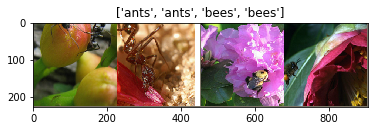

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Entrenamiento del modelo

El código siguiente corresponde la función que entrena el modelo. 

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualización de las predicciones del modelo

Función genérica para mostrar predicciones para unas pocas imágenes

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/fr4j4/.torch/models/resnet18-5c106cde.pth
46827520it [00:14, 3143998.42it/s]


## Transfer Learning: método 1

A continuación, utilizaremos un primer metodo de transfer learning para resolver nuestro problema. Cargaremos un modelo ConvNet preentrenado como base para resolver nuestro problema de clasificación.

<b>Preguntas</b>

- 1) ¿Como se llama el modelo ConvNet que utilizamos como base?

- 2) ¿Qué contiene la variable 'model_ft.fc'? ¿Cuántos variables de input y output tiene?

- 3) ¿Cuántas capas tiene la red 'fully-connected'?

- 4) ¿Cuáles son los parametros del modelo que actualizamos? ¿A qué método de transfer learning corresponde?

**Respuestas**<br>
1. El modelo se llama "resnet18"
2. Contiene el resultado de uns transformación lineal aplicada a los parámetros de entrada. Estos parámetros son Cantidad de datos de entrada y cantidad de datos de salida.
3. ?
4. Los parámetros son: 
 - Modelo: El modelo previamente instanciado.
 - Criterio: Es utilizado para la evaluación el ajuste del modelo.
 - Optimizador: Técnica de optimización para actualizar los pesos asociados.
 - Planificador: Método para ajustar la taza de aprendizaje.
 - Numero de epocas: Épocas <br> -
Corresponde al metodo "Perfeccionando el convnet"

Fase de entrenamiento. Esta fase puede demorar varios minutos (~15 minutos con CPU). Se puede modificar el número de epochs para terminar el entrenamiento más temprano.

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.7041 Acc: 0.6352
val Loss: 0.2575 Acc: 0.8889

Epoch 1/4
----------
train Loss: 0.6517 Acc: 0.7664
val Loss: 0.2387 Acc: 0.8954

Epoch 2/4
----------
train Loss: 0.4757 Acc: 0.7746
val Loss: 0.3280 Acc: 0.9020

Epoch 3/4
----------
train Loss: 0.7483 Acc: 0.7664
val Loss: 0.3155 Acc: 0.8562

Epoch 4/4
----------
train Loss: 0.7732 Acc: 0.6926
val Loss: 0.3376 Acc: 0.9020

Training complete in 8m 35s
Best val Acc: 0.901961


<b>Preguntas</b>

1) ¿En cuánto tiempo se optimizó la red?

2) ¿Con este método de transfer learning, cuál es el puntaje de exactitud que se obtiene con el dataset de test?

**Respuestas**<br> 
1. 8min con 35 segs 
2. 0.901961 es el puntaje de accuracy

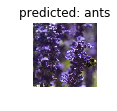

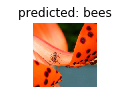

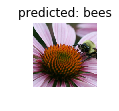

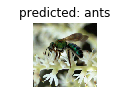

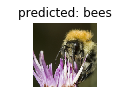

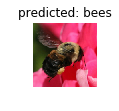

In [12]:
visualize_model(model_ft)

## Transfer Learning: método 2

A continuación, utilizaremos otro metodo de transfer learning para resolver nuestro problema. Cargaremos el mismo modelo ConvNet de base para resolver nuestro problema de clasificación

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

<b>Preguntas</b>

1) ¿Qué parametros se optimizan en esta versión de transfer learning? ¿A qué linea de código corresponde?

2) ¿En cuánto tiempo se optimizó la red?

3) ¿Con este método de transfer learning, cuál es el puntaje de exactitud que se obtiene con el dataset de test?




In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6050 Acc: 0.6557
val Loss: 0.2414 Acc: 0.9216

Epoch 1/4
----------
train Loss: 0.5633 Acc: 0.7418
val Loss: 0.4410 Acc: 0.7908

Epoch 2/4
----------
train Loss: 0.5817 Acc: 0.7582
val Loss: 0.2110 Acc: 0.9281

Epoch 3/4
----------
train Loss: 0.2883 Acc: 0.8730
val Loss: 0.2572 Acc: 0.9216

Epoch 4/4
----------
train Loss: 0.5988 Acc: 0.7787
val Loss: 0.2150 Acc: 0.9412

Training complete in 3m 40s
Best val Acc: 0.941176


In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()fv

<b>Preguntas:</b>

1) Para esta problemática particular, ¿qué métodos de transfer learning funcionó mejor?

2) En general, ¿en qué situaciones es preferibles utilizar el m

**Respuestas**
1. El método de learning rate que mejor funcionó fué el segundo, tiene mejor accuracy (0.941176) y el entrenamiento se realizó en menos tiempo (3min con 40 seg)
2. 